<a href="https://colab.research.google.com/github/dorian-goueytes/L1_P-M1_MIASHS/blob/main/TD4_spatial_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maintien en mémoire de travail avec un réseau de neurones

**Dans ce TD nous allons construire un réseau de neurones pour modéliser la capacité à maintenir une information en mémoire de travail (mémoire à court terme). L'exercice d'aujourd'hui s'inspire des travaux de Compte et collègues [1], et est adapté d'un exercice du site Neuronal Dynamics [2]**

**Ce réseau de neurones a été construit pour reproduire les résultats d'une tâche oculomotrice avec délai effectué chez des singes [3]. Dans cette tâche, on présente à un singe une cible visuelle pouvant appaître à différentes positions sur un cercle centrée sur une croix de fixation. Le singe doit ensuite garder en mémoire cette position pendant une durée donnée, et une fois cette durée écoulée effectuer une saccade oculaire vers l'emplacement dans lequel la cible à été présentée.**

**[English]** In this tutorial we are going to build a neural network to model the ability to maintain information in working memory (short-term memory). Today's exercise is inspired by the work of Compte and colleagues [1], and is adapted from an exercise on the Neuronal Dynamics website [2].

This neural network was built to reproduce the results of a delayed oculomotor response task performed on monkeys [3]. In this task, a monkey is presented with a visual target that can appear at different positions on a circle centred on a fixation cross. The monkey is then asked to memorise this position for a given period of time, and once this period has elapsed to perform an ocular saccade towards the location in which the target was presented.

![texte du lien](https://www.researchgate.net/profile/Christos-Constantinidis/publication/11005708/figure/fig1/AS:404930675396608@1473554404944/Oculomotor-delayed-response-ODR-task-Successive-panels-indicate-initial-appearance-of.png)

**La question est la suivante : Comment, au niveau neuronal, est-il possible de maintenir en mémoire durant le délai l'information sur la position de la cible?**

**Pour expliquer ce phénomène, Compte et collègues proposent de construire un réseau de neurones contenant des neurones excitateurs et inhibiteurs. Les neurones excitateurs sont séparés spatialement en fonction de la position de la cible à laquelle ils vont être sensible.**

**Chaque sous-population de neurones excitateurs lorsqu'elle est activée par un stimulus auquel elle est sensible va s'auto-stimuler et stimuler les sous-populations excitatrices à proximité. Elle va également stimuler une sous-population de neurones inhibiteurs, qui vont aller inhiber l'activité des sous-populations excitatrices ne correspondant pas au stimulus présenté.**

**L'image ci-dessous illustre l'organisation spatiale du réseau de neurones, et les connections entre les différentes sous-populations.**

**[English] **The question is as follows: How, at the neuronal level, is it possible to retain information about the target's position in memory during the delay?

To explain this phenomenon, Compte and colleagues propose to construct a neural network containing excitatory and inhibitory neurons. The excitatory neurons are spatially separated according to the position of the target to which they are going to be sensitive.

Each sub-population of excitatory neurons, when activated by a stimulus to which it is sensitive, will self-stimulate and stimulate nearby excitatory sub-populations. It will also stimulate a subpopulation of inhibitory neurons, which will inhibit the activity of excitatory subpopulations that do not correspond to the stimulus presented.

The image below illustrates the spatial organisation of the neuron network and the connections between the different sub-populations.

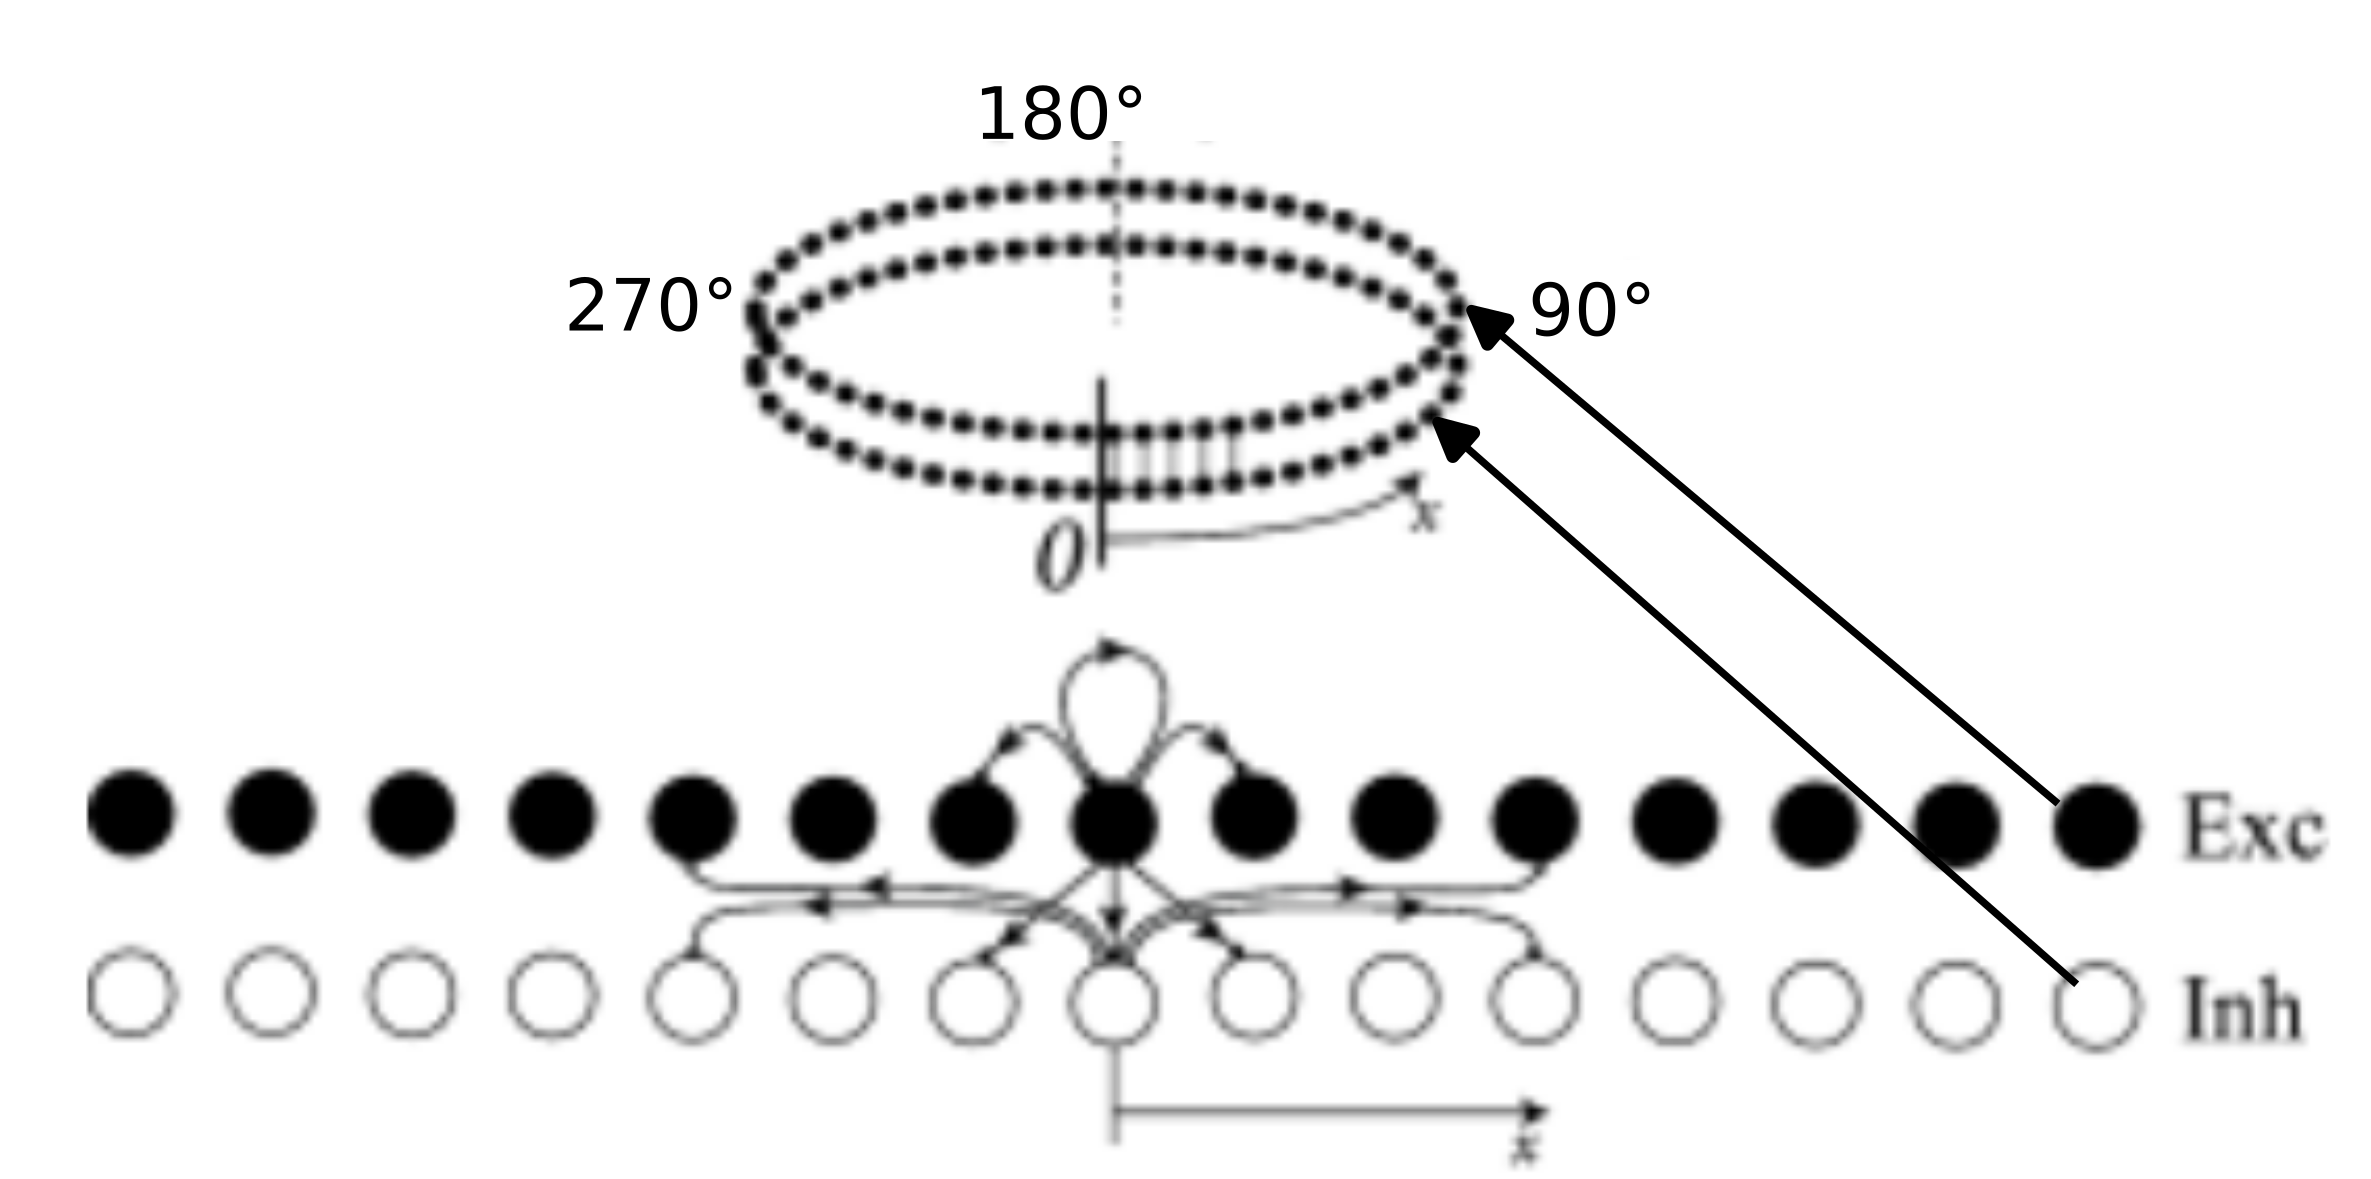


[1] Compte, A. (2000). Synaptic Mechanisms and Network Dynamics Underlying Spatial Working Memory in a Cortical Network Model. Cerebral Cortex, 10(9), 910–923. https://doi.org/10.1093/cercor/10.9.910


[2] https://neuronaldynamics-exercises.readthedocs.io/en/latest/index.html

[3] Funahashi, S., Bruce, C. J., & Goldman-Rakic, P. S. (1989). Mnemonic coding of visual space in the monkey’s dorsolateral prefrontal cortex. Journal of Neurophysiology, 61(2), 331–349. https://doi.org/10.1152/jn.1989.61.2.331


## Installation des pré-requis (il peut-être nécessaire de redémarrer la session pour valider l'installation)


In [ ]:
#@title Installation des pré-requis
!pip install neurodynex3
!pip install brian2

## Importation des outils nécessaires

In [ ]:
#@title Vous devez lancer cette cellule avant de pouvoir faire les exercices
from neurodynex3.working_memory_network import wm_model
from neurodynex3.tools import plot_tools
import brian2 as b2
import matplotlib.pyplot as plt

def plot_network(stim_start, stim_stop, stim_int,rate_monitor, spike_monitor, voltage_monitor=None, spike_train_idx_list=None,
                          t_min=None, t_max=None, N_highlighted_spiketrains=3, avg_window_width=50. * b2.ms,
                          sup_title=None, figure_size=(10, 4), dist_start = 0, dist_stop = 0, dist_int = 0):
    """
    Visualizes the results of a network simulation: spike-train, population activity and voltage-traces.

    Args:
        rate_monitor (PopulationRateMonitor): rate of the population
        spike_monitor (SpikeMonitor): spike trains of individual neurons
        voltage_monitor (StateMonitor): optional. voltage traces of some (same as in spike_train_idx_list) neurons
        spike_train_idx_list (list): optional. A list of neuron indices whose spike-train is plotted.
            If no list is provided, all (up to 500) spike-trains in the spike_monitor are plotted. If None, the
            the list in voltage_monitor.record is used.
        t_min (Quantity): optional. lower bound of the plotted time interval.
            if t_min is None, it is set to the larger of [0ms, (t_max - 100ms)]
        t_max (Quantity): optional. upper bound of the plotted time interval.
            if t_max is None, it is set to the timestamp of the last spike in
        N_highlighted_spiketrains (int): optional. Number of spike trains visually highlighted, defaults to 3
            If N_highlighted_spiketrains==0 and voltage_monitor is not None, then all voltage traces of
            the voltage_monitor are plotted. Otherwise N_highlighted_spiketrains voltage traces are plotted.
        avg_window_width (Quantity): optional. Before plotting the population rate (PopulationRateMonitor), the rate
            is smoothed using a window of width = avg_window_width. Defaults is 1.0ms
        sup_title (String): figure suptitle. Default is None.
        figure_size (tuple): (width,height) tuple passed to pyplot's figsize parameter.

    Returns:
        Figure: The whole figure
        Axes: Top panel, Raster plot
        Axes: Middle panel, population activity
        Axes: Bottom panel, voltage traces. None if no voltage monitor is provided.
    """
    import numpy
    assert isinstance(rate_monitor, b2.PopulationRateMonitor), \
        "rate_monitor  is not of type PopulationRateMonitor"
    assert isinstance(spike_monitor, b2.SpikeMonitor), \
        "spike_monitor is not of type SpikeMonitor"
    #assert (voltage_monitor is None) or (isinstance(voltage_monitor, b2.StateMonitor)), \
     #   "voltage_monitor is not of type StateMonitor"
    assert (spike_train_idx_list is None) or (isinstance(spike_train_idx_list, list)), \
        "spike_train_idx_list is not of type list"

    all_spike_trains = spike_monitor.spike_trains()
    if spike_train_idx_list is None:
        if True is not None:
            # if no index list is provided use the one from the voltage monitor
            spike_train_idx_list = numpy.sort(voltage_monitor.record)
        else:
            # no index list AND no voltage monitor: plot all spike trains
            spike_train_idx_list = numpy.sort(all_spike_trains.keys())
        if len(spike_train_idx_list) > 5000:
            # avoid slow plotting of a large set
            print("Warning: raster plot with more than 5000 neurons truncated!")
            spike_train_idx_list = spike_train_idx_list[:5000]

    # get a reasonable default interval
    if t_max is None:
        t_max = max(rate_monitor.t / b2.ms)
    else:
        t_max = t_max / b2.ms
    if t_min is None:
        t_min = max(0., t_max - 100.)  # if none, plot at most the last 100ms
    else:
        t_min = t_min / b2.ms

    fig = None
    ax_raster = None
    ax_rate = None
    ax_voltage = None
    #if voltage_monitor is None:
    fig, (ax_raster, ax_rate) = plt.subplots(2, 1, sharex=True, figsize=figure_size)
    #else:
        #fig, (ax_raster, ax_rate, ax_voltage) = plt.subplots(3, 1, sharex=True, figsize=figure_size)

    # nested helpers to plot the parts, note that they use parameters defined outside.
    def get_spike_train_ts_indices(spike_train):
        """
        Helper. Extracts the spikes within the time window from the spike train
        """
        ts = spike_train/b2.ms
        # spike_within_time_window = (ts >= t_min) & (ts <= t_max)
        # idx_spikes = numpy.where(spike_within_time_window)
        idx_spikes = (ts >= t_min) & (ts <= t_max)
        ts_spikes = ts[idx_spikes]
        return idx_spikes, ts_spikes

    def plot_raster():
        """
        Helper. Plots the spike trains of the spikes in spike_train_idx_list
        """
        neuron_counter = 0
        for neuron_index in spike_train_idx_list:
            idx_spikes, ts_spikes = get_spike_train_ts_indices(all_spike_trains[neuron_index])
            ax_raster.scatter(ts_spikes, neuron_counter * numpy.ones(ts_spikes.shape),
                              marker=".", c="k", s=15, lw=0)
            neuron_counter += 1
        ax_raster.set_ylim([0, neuron_counter])
        ax_raster.set_ylabel("neuron N°")
        ax_raster.set_title("Raster Plot", fontsize=10)
        ax_raster.hlines(y=0, xmin=stim_start, xmax=stim_stop, linewidth=10, color='b', alpha = stim_int, label =  'Stimulus')
        if dist_int!=0:
          ax_raster.hlines(y=0, xmin=dist_start, xmax=dist_stop, linewidth=10, color='r', alpha = dist_int, label =  'Distractor')


    def plot_population_activity(window_width=100*b2.ms):
        """
        Helper. Plots the population rate and a mean
        """
        ts = rate_monitor.t / b2.ms
        idx_rate = (ts >= t_min) & (ts <= t_max)
        # ax_rate.plot(ts[idx_rate],rate_monitor.rate[idx_rate]/b2.Hz, ".k", markersize=2)
        smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window_width)/b2.Hz
        ax_rate.plot(ts[idx_rate], smoothed_rates[idx_rate])
        ax_rate.set_ylabel("Taux de décharge [Hz]")
        ax_rate.set_title("Activité moyenne de la population", fontsize=10)
        ax_rate.hlines(y=0, xmin=stim_start, xmax=stim_stop, linewidth=10, color='b', alpha = stim_int, label =  'Stimulus')
        if dist_int!=0:
          ax_rate.hlines(y=0, xmin=dist_start, xmax=dist_stop, linewidth=10, color='r', alpha = dist_int, label =  'Distractor')


    plot_raster()
    plot_population_activity(avg_window_width)
    nr_neurons = len(spike_train_idx_list)


    plt.xlabel("temps [ms]")
    plt.legend()
    plt.suptitle("Activité des neurones excitateurs")
    plt.tight_layout()
    if sup_title is not None:
        plt.suptitle(sup_title)

    return fig, ax_raster, ax_rate, ax_voltage

## Partie 1 : Comprendre l'activité du réseaux

**Q01 : Lancez la cellule suivante et décrivez la figure qui en résulte. Expliquez brièvement à quoi correspond chaque sous-figure**

Q01 : Run the following cell and describe the resulting figure. Explain briefly what each sub-figure corresponds to

In [ ]:
#@title Activité de notre réseau récurrent de neurones au repos
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(stimulus_center_deg=180, stimulus_width_deg=30, stimulus_strength=.1 * b2.namp, t_stimulus_start=100 * b2.ms, t_stimulus_duration=200 * b2.ms, sim_time=1000. * b2.ms)
plot_network(100,200,0.1,rate_monitor_excit, spike_monitor_excit,voltage_monitor_excit, t_min=0. * b2.ms)
plt.show()

### Initier la rétention en mémoire de travail

**Q02 : Décrivez les changements sur la figure lorsque vous augmentez stim_int?**

Q02: Describe the changes in the figure when you increase stim_int?

**Q03 : Quel est le phénomène qui se met en place pour les valeurs de stim_int supérieures au minimum?**

Q03: What is the name of the process observed when stim_int is greater than the minimum?


In [ ]:
#@title Manipulation de stim_int

stim_int = 0.1# @param {type:"slider", min:0.1, max:1, step:0.1}
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(stimulus_center_deg=180, stimulus_width_deg=30, stimulus_strength=stim_int * b2.namp, t_stimulus_start=100 * b2.ms, t_stimulus_duration=200 * b2.ms, sim_time=1000. * b2.ms)
plot_network(100,200,stim_int,rate_monitor_excit, spike_monitor_excit,voltage_monitor_excit, t_min=0. * b2.ms)
plt.show()

## Partie 2 : Manipulation du stimulus

Nous allons maintenant fixer l'intensité du stimulus et nous intéresser à ses caractéristiques spatiales

**Q04 : Qu'observez vous lorsque vous manipulez la variable "degree"? Selon vous à quoi correspond-t-elle dans l'expérience originale?**

Q04 : What do you observe when you manipulate the ‘degree’ variable? What do you think it corresponds to in the original experiment?

**Q05 : Qu'observez-vous lorsque vous manipulez la variable "size"? Selon vous à quoi correspond-t-elle dans l'expérience originale?**

Q05: What do you observe when you manipulate the ‘size’ variable? What do you think it corresponds to in the original experiment?

In [ ]:
#@title Manipulation des caractéristiques spatiales du stimulus

degree = 180# @param {type:"slider", min:0, max:360, step:10}
size = 30# @param {type:"slider", min:0, max:360, step:10}
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(stimulus_center_deg=degree, stimulus_width_deg=size, stimulus_strength=0.2 * b2.namp, t_stimulus_start=100 * b2.ms, t_stimulus_duration=200 * b2.ms, sim_time=1000. * b2.ms)
plot_network(100,200,stim_int,rate_monitor_excit, spike_monitor_excit,voltage_monitor_excit, t_min=0. * b2.ms)
plt.show()

## Partie 3 : Ajout d'un distracteur

**Nous allons maintenant ajouter un distracteur et observer la manière dont le réseau de neurones se comporte. Rappel, un distracteur est un second stimulus qui peut rentrer en conflit avec le premier.**

We are now going to add a distractor and observe how the neural network behaves. Remember, a distractor is a second stimulus that may conflict with the first.

-

**Q06 : Commencez par lancer une stimulation avec le paramètre dist_int à 0.1. Qu'observez-vous? Quel est selon vous l'impact du distracteur sur la mémorisation du stimulus initial?**

Q06 : Start by running a stimulation with the dist_int parameter set to 0.1. What do you observe? What impact do you think the distractor has on the recall of the initial stimulus?

**Q07 : Qu'observez-vous lorsque vous augmentez le paramètre dist_int? Dans cette configuration, que se passe-t-il en termes de mémorisation?**

Q07: What do you observe when you increase the dist_int parameter? In this configuration, what happens in terms of memory storage?

In [ ]:
#@title Ajout d'un distracteur
dist_angle = 320
dist_size = 30
dist_start = 500
dist_dur = 200
dist_int = 0.1# @param {type:"slider", min:0.1, max:0.9, step:0.1}
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(stimulus_center_deg=180, stimulus_width_deg=30, stimulus_strength=0.2 * b2.namp, t_stimulus_start=100 * b2.ms, t_stimulus_duration=200 * b2.ms, sim_time=1000. * b2.ms,distractor_center_deg = dist_angle, distractor_width_deg = dist_size, t_distractor_start = dist_start* b2.ms,t_distractor_duration = dist_dur* b2.ms, distractor_strength=dist_int * b2.namp,)
plot_network(100,200,stim_int,rate_monitor_excit, spike_monitor_excit,voltage_monitor_excit, t_min=0. * b2.ms, dist_start = dist_start, dist_stop = dist_start+dist_dur, dist_int = dist_int)
plt.show()

## Effet des neurones inhibiteurs

**Comme cela a été expliqué dans l'énoncé, le réseau de neurones que nous étudions est basé sur la présence de deux populations de neurones, une excitatrices et l'autre inhibitrice.**
**Pour la prochaine simulation nous allons supprimer la population inhibitrice et observer les conséquences sur la performance de notre réseau de neurones.**

As explained in the instructions, the neural network we are studying is based on the presence of two populations of neurons, one excitatory and the other inhibitory.
For the next simulation we will remove the inhibitory population and observe the consequences on the performance of our neural network.

**Q08 : Décrivez l'effet de supprimer la partie inhibitrice du réseau. En vous basant entre autre sur le schéma du réseau et le contenu de l'énoncé, pouvez vous expliquez ce que vous observez?**

Q08: Describe the effect of removing the inhibitory part of the network. Based on the diagram of the network and the content of the instructions, can you explain what you observe?

In [ ]:
#@title Simulation sans inhibition
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(N_inhibitory = 1,stimulus_center_deg=180, stimulus_width_deg=30, stimulus_strength=0.3 * b2.namp, t_stimulus_start=100 * b2.ms, t_stimulus_duration=200 * b2.ms, sim_time=1000. * b2.ms)
plot_network(100,200,stim_int,rate_monitor_excit, spike_monitor_excit,voltage_monitor_excit, t_min=0. * b2.ms)
plt.show()


## Effet de la connexion récurrente

**Une autre caractéristique de notre réseau est que les sous-populations excitatrices sont récurrentes, c'est à dire qu'elles s'auto-stimulent une fois qu'elles ont été activées.**
**Dans la simulation suivant on peut observer les résultats d'un modèle avec ces connexions récurrentes (première figure) et d'un modèle sans (deuxième figure) pour un même stimulus.**

Another feature of our network is that the excitatory sub-populations are recurrent, i.e. they self-stimulate once they have been activated.
In the following simulation we can see the results of a model with these recurrent connections (first figure) and a model without (second figure) for the same stimulus.

**Q09 : Décrivez l'effet de supprimer les connexions récurrentes. En vous basant entre autre sur le schéma du réseau et le contenu de l'énoncé, pouvez vous expliquez ce que vous observez?**

Q09: Describe the effect of removing recurrent connections. Based on the diagram of the network and the content of the instructions, can you explain what you observe?

In [ ]:
#@title Simulation avec et sans connexions récurrentes
stim_int = 0.7
rate_monitor_excit_re, spike_monitor_excit_re, voltage_monitor_excit_re, idx_monitored_neurons_excit_re, rate_monitor_inhib_re, spike_monitor_inhib_re, voltage_monitor_inhib_re, idx_monitored_neurons_inhib_re, w_profile = wm_model.simulate_wm(stimulus_center_deg=180, stimulus_width_deg=30, stimulus_strength=stim_int * b2.namp, t_stimulus_start=100 * b2.ms, t_stimulus_duration=200 * b2.ms, sim_time=1000. * b2.ms)
plot_network(100,200,stim_int,rate_monitor_excit_re, spike_monitor_excit_re,voltage_monitor_excit_re, t_min=0. * b2.ms)
plt.suptitle("Activité d'un réseau avec connexions récurrentes")
plt.show()
print()
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(Jpos_excit2excit = 0, stimulus_center_deg=180, stimulus_width_deg=30, stimulus_strength=stim_int * b2.namp, t_stimulus_start=100 * b2.ms, t_stimulus_duration=200 * b2.ms, sim_time=1000. * b2.ms)
plot_network(100,200,stim_int,rate_monitor_excit, spike_monitor_excit,voltage_monitor_excit, t_min=0. * b2.ms)
plt.suptitle("Activité d'un réseau sans connexions récurrentes")
plt.show()
